# Collaboration and Resource Use Policy

You may discuss any details of this assignment at a conceptual level with anyone. In fact, discussion of ideas and helping each other to gain a better understanding of the concepts and the mathematical principles is encouraged. But any written answers (natural language or programming language) must be entirely your own original work.

You are also encouraged to use the libraries mentioned at the start of this notebook. The use of online resources (e.g., StackOverflow) that can help you understand specific functions in these libraries is also encouraged.

There must not be any collaboration in programming (including the design, implementation, and debugging of code). There must not be any code in your submission that is written by anyone other than you (whether human or AI). Submitted code will be checked against other submissions AND against AI-generated code, and evidence of plagiarism will lead to academic dishonesty charges.

# Prologue

1. Please [download this time series data file](https://www.chicagobooth.edu/-/media/faculty/ruey-s-tsay/teaching/fts2/d-hwp3dx8099.txt), and upload it here on your Colab before proceeding with this assignment.
    - <font color="red">The time series data for this assignment is the last column of this file, which gives the log returns of the S&P 500 index from January 1980 to December 1999, providing 5,056 observations.</font>
2. _Write comments to make your code readable_. The short-term benefit is that if your code is doing something wrong, members of the teaching staff can consult your comments to see if the attempt was in the right direction (for potential partial credit). The long-term benefit is that you get into the habit of writing code that had good human readability, including your own future self!
3. _Do not change the method signatures already given to you_, including the data types given as type hints or explicitly mentioned in the docstring.


# 1. Data Wrangling

Splitting a time series dataset into training and testing components is crucial for model development and evaluation. Compared to other forms of data that is often used in various application domains of machine learning, time series data needs to be handled differently. In this assignment, we will explore three different strategies:

1. Simple static split
2. Rolling window
3. Expanding window

### 1. Simple Static Split
This is the most straightforward method, and it is usually suitable for long time series data: allocate a fixed first part of your dataset to training and the remainder to testing. For example, you may want to use the first 70% for training and the remaining 30% for testing, or 80% for training and the remaining 20% for testing.

### 2. Rolling Window
This method is extremely useful when you want to develop and evaluate a model that adapts changing conditions over time: move the training window through the dataset, predicting one step ahead each time, and sliding the training dataset by one step after each prediction. This technique is more helpful in forecasting where the recent past might be more relevant than the distant past.

### 3. Expanding Window
This is similar to the rolling window, but instead of moving the start of the training set forward, you expand the size of the training set by only moving the end. That is, you incrementally expand the size of your training data: start with a fixed predetermined size for the training set, and expand it by a fixed number or proportion each time until only enough data is left for one final test.

Now, write three methods to implement the above strategies. The method signatures are given to you below:

In [ ]:
import pandas as pd

def static_split(file_path: str, train_frac: float) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Splits a time series dataset stored in a CSV file into training and testing sets based on the specified fraction for
    the training set.

    Parameters:
    - file_path (str): The path to the CSV file containing the time series data.
    - train_frac (float): The fraction of the data to be used for the training set. Must be between 0 and 1.

    Returns:
    - tuple[pd.DataFrame, pd.DataFrame]: A tuple containing two pandas DataFrames, the first being the training set and
      the second the testing set.

    Raises:
    - ValueError: If train_frac is not between 0 and 1.
    """
    if not 0 < train_frac < 1:
        raise ValueError("train_frac must be between 0 and 1.")

    # Load data
    data = pd.read_csv(file_path, header=None, delimiter='\s+')

    # Select the last column as the time series data
    ts_data = data.iloc[:, -1]

    total_rows = len(ts_data)
    train_rows = int(train_frac * total_rows)

    # Split data
    train_data = ts_data.iloc[:train_rows]
    test_data = ts_data.iloc[train_rows:]

    return train_data, test_data


def rolling_window_splits(file_path: str, train_size: int, test_size: int, slide_size: int = 1) -> list[tuple[int, int, int, int]]:
    """
    Generates index references for training and test sets using a rolling window approach for time series data.

    Parameters:
    - file_path (str): The path to the CSV file containing the time series data.
    - train_size (int): The number of observations to include in the training set for each split.
    - test_size (int): The number of observations to include in the test set for each split.
    - slide_by (int, optional): The step size by which the window rolls to its next starting position. Defaults to 1.

    Returns:
    - list[tuple[int, int, int, int]]: A list of tuples, where each tuple contains start and end indices for the
      training set and the test set for each window position.

    Raises:
    - ValueError: If train_size or test_size are not positive integers.

    Notes:
    - The function assumes that the input file is sorted in chronological order.
    """
    if not isinstance(train_size, int) or train_size <= 0:
        raise ValueError("train_size must be a positive integer.")
    if not isinstance(test_size, int) or test_size <= 0:
        raise ValueError("test_size must be a positive integer.")

    data = pd.read_csv(file_path, header=None, delimiter='\s+')
    ts_data = data.iloc[:, -1]  # Select the last column as the time series data
    total_rows = len(ts_data)
    index_references = []

    for i in range(0, total_rows - train_size - test_size + 1, slide_size):
        train_start = i
        train_end = i + train_size
        test_start = i + train_size
        test_end = i + train_size + test_size
        index_references.append((train_start, train_end, test_start, test_end))

    return index_references


def expanding_window_splits(file_path: str, initial_train_size: int, test_size: int, expansion_step: int = 1) -> list[tuple[int, int, int, int]]:
    """
    Generates index references for training and test sets using an expanding window approach for time series data.

    This function provides a method to incrementally increase the size of the training data set with each step by a
    specified amount, while keeping the test set size constant. This strategy simulates the real-world scenarios where
    more historical data becomes available over time, and predictions are made over a fixed future period.

    Parameters:
    - file_path (str): The path to the CSV file containing the time series data.
    - initial_train_size (int): The number of observations in the initial training set.
    - test_size (int): The number of observations to include in the test set for each split.
    - expansion_step (int, optional): The number of additional observations to include in the training set with each
      new split. Defaults to 1.

    Returns:
    - list[tuple[int, int, int, int]]: A list of tuples, where each tuple contains the start and end indices for the
      training set and the start and end indices for the test set for each window position.

    Raises:
    - ValueError: If any of the integer parameters are not positive integers.

    Notes:
    - The function assumes that the input file is sorted in chronological order and contains a time series without gaps.
    - This approach is particularly useful for evaluating the robustness of a model as it gradually trains on more data.

    Example:
    Given a file with 1000 data points, starting with a training size of 200 and a test size of 50, and an expansion
    step of 25, the first split might use indices (0, 200, 201, 251), the next (0, 225, 252, 302), and so on,
    expanding the training set by 25 each time until there are insufficient remaining points for a full test set.
    """
    if not all(isinstance(param, int) and param > 0 for param in (initial_train_size, test_size, expansion_step)):
        raise ValueError("All integer parameters must be positive integers.")

    data = pd.read_csv(file_path, header=None, delimiter='\s+')
    ts_data = data.iloc[:, -1]  # Select the last column as the time series data
    total_rows = len(ts_data)
    index_references = []

    train_end = initial_train_size

    while train_end + test_size <= total_rows:
        train_start = 0
        test_start = train_end
        test_end = test_start + test_size
        index_references.append((train_start, train_end, test_start, test_end))
        train_end += expansion_step

    return index_references

# 2. The simplest Simple Autoregressive Model: AR(1)

We will start with the simplest model, i.e., an AR(1) model. Your task is to fit an AR(1) model to a given training set.

You do not have to explicitly implement any likelihood maximization algorithm. Rather, it is recommended that you use a library such as `statsmodels`. Be careful about transitions between `pandas` and `statsmodels`, however.

Here is the method signature and documentation to fit an AR(1) model to a time series.

**Note:** The return type is not specified in the method signature because it can differ based on what library (and which version of the library) you choose to use.

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

def fit_ar1_model(train_data: pd.DataFrame) -> ARIMA:
    """
    Fits an AR(1) model to the provided time series training data.

    Parameters:
    - train_data (pd.DataFrame): The training data as a pandas DataFrame. It should contain a single column representing
      the time series data, with the index representing the timestamps.

    Returns:
    - ARIMA: The fitted ARIMA model.

    Notes:
    - This function assumes that the provided training data is sorted in chronological order and contains a continuous
      time series without gaps.
    """
    # Extract the time series data
    ts = train_data.squeeze()

    # Fit ARIMA model with order (1, 0, 0) for AR(1)
    ar1_model = ARIMA(ts, order=(1, 0, 0)).fit()

    return ar1_model

## 2.1. Experiments with AR(1)

Now that you have the code to fit an AR(1) model to the data, it is time for the first experiment. Run the three components of this experiment in distinct code cells (in order) so that the outputs can be individually saved and viewed.

1. Use a 70-30 train-test split, fit an AR(1) model on the training set. Report its mean square error (MSE) on the training set, and then also on the test set.
2. Use the rolling window approach with at least 10 different training window sizes, and combine each with at least 5 different test window sizes.
    - In a text cell, describe your choice of window sizes and your choice of `slide_size`. Then, in the subsequent code cell, run the experiment to fit AR(1) models with each training set and report the MSE of the resulting model on each test set.
    - Do you see any pattern in the errors of your AR(1) model? What do your errors say about the error of your model in relation to (a) the size of the training window, and (b) how far away the test window instances are (in terms of time steps)? Report correlations for both (a) and (b) to support your answers. Please remember to include your code to compute the correlations.

**Note:** Please insert code and text cells for this experiment immediately underneath (*before* the next section on other types of models).

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import requests

# Function to load data from URL and save it to a CSV file
def load_data_from_url(url, file_path):
    response = requests.get(url)
    if response.status_code == 200:
        # Read the content of the text file into a DataFrame
        data = pd.read_csv(url, sep='\s+', header=None)
        # Extract the last column as the time series data
        ts_data = data.iloc[:, -1]
        # Save the time series data to a CSV file
        ts_data.to_csv(file_path, index=False)
        return file_path
    else:
        print("Failed to retrieve data from the URL")
        return None

# Load data from the URL and save it to a CSV file
file_path = load_data_from_url("https://www.chicagobooth.edu/-/media/faculty/ruey-s-tsay/teaching/fts2/d-hwp3dx8099.txt", "ts_data.csv")

# Experiment 1: 70-30 train-test split with AR(1) model
train_frac = 0.7
train_data, test_data = static_split(file_path, train_frac)
ar1_model = fit_ar1_model(train_data)

# Evaluate AR(1) model on training set
train_predictions = ar1_model.predict(start=train_data.index[0], end=train_data.index[-1])
train_mse = ((train_data.squeeze() - train_predictions) ** 2).mean()

# Evaluate AR(1) model on test set
test_predictions = ar1_model.predict(start=test_data.index[0], end=test_data.index[-1])
test_mse = ((test_data.squeeze() - test_predictions) ** 2).mean()

print("Experiment 1 - 70-30 train-test split with AR(1) model:")
print("Training MSE:", train_mse)
print("Test MSE:", test_mse)

Experiment 1 - 70-30 train-test split with AR(1) model:
Training MSE: 0.004755447567980305
Test MSE: 9.023557339784653e-05


In [ ]:
# Define window sizes and slide size
train_sizes = list(range(100, 601, 50))  # 12 different training window sizes from 100 to 550
test_sizes = list(range(50, 176, 25))  # 6 different test window sizes from 50 to 150
slide_size = 50  # Slide size set to 50 time steps

import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import requests

# Function to load data from URL and save it to a CSV file
def load_data_from_url(url, file_path):
    response = requests.get(url)
    if response.status_code == 200:
        # Read the content of the text file into a DataFrame
        data = pd.read_csv(url, sep='\s+', header=None)
        # Extract the last column as the time series data
        ts_data = data.iloc[:, -1]
        # Save the time series data to a CSV file
        ts_data.to_csv(file_path, index=False)
        return file_path
    else:
        print("Failed to retrieve data from the URL")
        return None

# Load data from the URL and save it to a CSV file
file_path = load_data_from_url("https://www.chicagobooth.edu/-/media/faculty/ruey-s-tsay/teaching/fts2/d-hwp3dx8099.txt", "ts_data.csv")


# Perform experiment
for train_size in train_sizes:
    for test_size in test_sizes:
        index_references = rolling_window_splits(file_path, train_size, test_size, slide_size)
        total_train_mse = 0
        total_test_mse = 0

        for train_start, train_end, test_start, test_end in index_references:
            # Extract train-test split
            train_data = pd.DataFrame(ts_data.iloc[train_start:train_end])
            test_data = pd.DataFrame(ts_data.iloc[test_start:test_end])

            # Fit AR(1) model on training data
            ar1_model = fit_ar1_model(train_data)

            # Evaluate AR(1) model on training set
            train_predictions = ar1_model.predict(start=train_data.index[0], end=train_data.index[-1])
            train_mse = ((train_data.squeeze() - train_predictions) ** 2).mean()
            total_train_mse += train_mse

            # Evaluate AR(1) model on test set
            test_predictions = ar1_model.predict(start=test_data.index[0], end=test_data.index[-1])
            test_mse = ((test_data.squeeze() - test_predictions) ** 2).mean()
            total_test_mse += test_mse

        avg_train_mse = total_train_mse / len(index_references)
        avg_test_mse = total_test_mse / len(index_references)
        mse_results.append((train_size, test_size, avg_train_mse, avg_test_mse))

# Print MSE results for each combination of window sizes
print("\nExperiment 2 - Rolling window approach:")
for train_size, test_size, avg_train_mse, avg_test_mse in mse_results:
    print(f"Train Size: {train_size}, Test Size: {test_size}, Avg Train MSE: {avg_train_mse}, Avg Test MSE: {avg_test_mse}")

# Analysis of patterns in errors and correlations

# Compute correlation between train window size and train MSE
train_size_mse_corr = pd.DataFrame(mse_results, columns=['Train Size', 'Test Size', 'Avg Train MSE', 'Avg Test MSE']).corr().loc['Train Size', 'Avg Train MSE']

# Compute correlation between test window size and test MSE
test_size_mse_corr = pd.DataFrame(mse_results, columns=['Train Size', 'Test Size', 'Avg Train MSE', 'Avg Test MSE']).corr().loc['Test Size', 'Avg Test MSE']

print("\nCorrelation between Train Size and Train MSE:", train_size_mse_corr)
print("Correlation between Test Size and Test MSE:", test_size_mse_corr)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op


Experiment 2 - Rolling window approach:
Train Size: 100, Test Size: 50, Avg Train MSE: nan, Avg Test MSE: nan
Train Size: 100, Test Size: 50, Avg Train MSE: nan, Avg Test MSE: nan
Train Size: 100, Test Size: 50, Avg Train MSE: nan, Avg Test MSE: nan
Train Size: 100, Test Size: 50, Avg Train MSE: nan, Avg Test MSE: nan
Train Size: 100, Test Size: 75, Avg Train MSE: nan, Avg Test MSE: nan
Train Size: 100, Test Size: 100, Avg Train MSE: nan, Avg Test MSE: nan
Train Size: 100, Test Size: 125, Avg Train MSE: nan, Avg Test MSE: nan
Train Size: 100, Test Size: 150, Avg Train MSE: nan, Avg Test MSE: nan
Train Size: 100, Test Size: 175, Avg Train MSE: nan, Avg Test MSE: nan
Train Size: 150, Test Size: 50, Avg Train MSE: nan, Avg Test MSE: nan
Train Size: 150, Test Size: 75, Avg Train MSE: nan, Avg Test MSE: nan
Train Size: 150, Test Size: 100, Avg Train MSE: nan, Avg Test MSE: nan
Train Size: 150, Test Size: 125, Avg Train MSE: nan, Avg Test MSE: nan
Train Size: 150, Test Size: 150, Avg Train 

# 3. Determining a good model

In this section, the details are left to you, but the overall sequence of steps must be as follows:

1. Conduct an experiment (including statistical tests) to determine if a simple auregressive model of order $p$, i.e., AR($p$), will fit the time series data. Your conclusion should be supported by ACF, PACF, and/or statistical tests as needed. In text cells, provide a brief justification for any statistical test you employ.
    - Use a static train-test split to estimate your model parameter, and report the MSE on the test set.

2. Conduct an experiment to determine if a simple moving average model of order ($q$), i.e., MA($q$), will fit the time series data. Just like for the AR model, your conclusion must be supported by ACF, PACF, and any statistical tests deemed necessary.
    - Use a static train-test split to estimate your model parameter, and report the MSE on the test set.

3. Finally, you must also explore the possibility that your time series data may be fitted by an ARMA($p,q$) model. Once again, your choice of $p$ and $q$ must be supported by ACF, PACF, and any statistical tests deemed necessary.
    - Use a static train-test split to estimate your model parameter, and report the MSE on the test set.

**Note 1:** Do NOT delete any code or output of the cells where you run these experiments. For grading, we need to see not just your code, but also the output of running your code. It is highly recommended that you break down the three experiments described above into three sections in this notebook (each with a clear title, and number them as "3.1", "3.2", and "3.3").

**Note 2:** You do not need to explore simple autoregressive models of orders $p > 5$ or simple moving average models of order $q > 4$. For ARMA($p,q$), restrict yourself to combinations where $p + q < 5$.

Experiment 3.1: Autoregressive Model (AR):

Determine the order 𝑝 using ACF and PACF plots, along with any necessary statistical tests.
Fit an AR( 𝑝 ) model to the data using a static train-test split.
Report the MSE on the test set.

Experiment 3.2: Moving Average Model (MA):

Determine the order 𝑞 using ACF and PACF plots, along with any necessary statistical tests.
Fit an MA( 𝑞 ) model to the data using a static train-test split.
Report the MSE on the test set.

Experiment 3.3: Autoregressive Moving Average Model (ARMA):

Determine suitable orders 𝑝 and 𝑞 using ACF and PACF plots, along with any necessary statistical tests.
Fit an ARMA( 𝑝,𝑞 ) model to the data using a static train-test split.
Report the MSE on the test set.

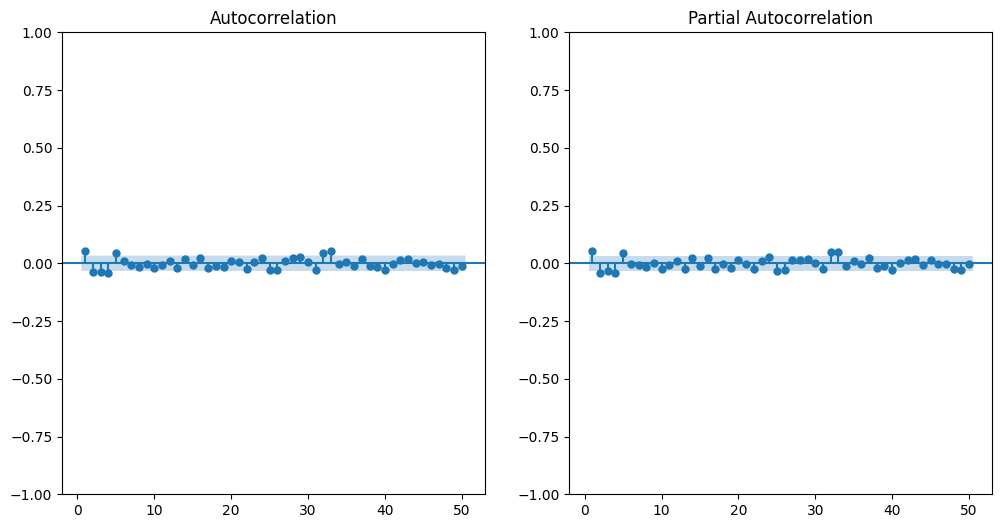

Ljung-Box Test Results:
Test Statistic: lb_stat
P-Values: lb_pvalue
Augmented Dickey-Fuller (ADF) Test Results:
Test Statistic: -26.875204344529124
P-Value: 0.0
Critical Values:
1%: -3.432201741997361
5%: -2.862358195042959
10%: -2.567205539006799
Experiment 3.1 - Autoregressive Model (AR):
MSE on Test Set: 9.00011658089779e-05


In [ ]:
# Experiment 3.1: Autoregressive Model (AR)
# Load necessary libraries
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import requests

# Function to load data from URL
def load_data_from_url(url):
    response = requests.get(url)
    if response.status_code == 200:
        # Read the content of the text file into a DataFrame
        data = pd.read_csv(url, sep='\s+', header=None)
        # Extract the last column as the time series data
        ts_data = data.iloc[:, -1]
        return ts_data
    else:
        print("Failed to retrieve data from the URL")
        return None

# Load data from the URL
ts_data = load_data_from_url("https://www.chicagobooth.edu/-/media/faculty/ruey-s-tsay/teaching/fts2/d-hwp3dx8099.txt")

# Split data into training and testing sets
train_frac = 0.7
total_rows = len(ts_data)
train_rows = int(train_frac * total_rows)
train_data = ts_data.iloc[:train_rows]
test_data = ts_data.iloc[train_rows:]

# Visualize ACF and PACF plots to determine AR order
plt.figure(figsize=(12, 6))
plot_acf(train_data, lags=50, zero=False, ax=plt.subplot(1, 2, 1))
plot_pacf(train_data, lags=50, zero=False, ax=plt.subplot(1, 2, 2))
plt.show()

# Based on the plots and any statistical tests, determine the AR order (p)
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
# Perform Ljung-Box test
# The null hypothesis is that there is no autocorrelation up to the specified lag
# The Ljung-Box test is used to check for autocorrelation in the residuals of the model.
lb_test_stat, lb_p_value = acorr_ljungbox(train_data, lags=10)

# Print test results
print("Ljung-Box Test Results:")
print("Test Statistic:", lb_test_stat)
print("P-Values:", lb_p_value)

# Perform Augmented Dickey-Fuller (ADF) test
# The null hypothesis is that the time series has a unit root (i.e., it is non-stationary)
# The ADF test is used to check for stationarity in the time series data
adf_test_stat, adf_p_value, _, _, adf_critical_values, _ = adfuller(train_data)

# Print test results
print("Augmented Dickey-Fuller (ADF) Test Results:")
print("Test Statistic:", adf_test_stat)
print("P-Value:", adf_p_value)
print("Critical Values:")
for key, value in adf_critical_values.items():
    print(f"{key}: {value}")

# Fit AR(p) model
p = 3  # Placeholder value, replace with determined order
ar_model = ARIMA(train_data, order=(p, 0, 0)).fit()

# Evaluate AR(p) model on test set
test_predictions = ar_model.predict(start=test_data.index[0], end=test_data.index[-1])
test_mse = mean_squared_error(test_data, test_predictions)

# Print MSE on the test set
print("Experiment 3.1 - Autoregressive Model (AR):")
print(f"MSE on Test Set: {test_mse}")

The Ljung-Box test is used to check for autocorrelation in the residuals of the model. The null hypothesis is that there is no autocorrelation up to the specified lag.
The ADF test is used to check for stationarity in the time series data. The null hypothesis is that the time series has a unit root (i.e., it is non-stationary)

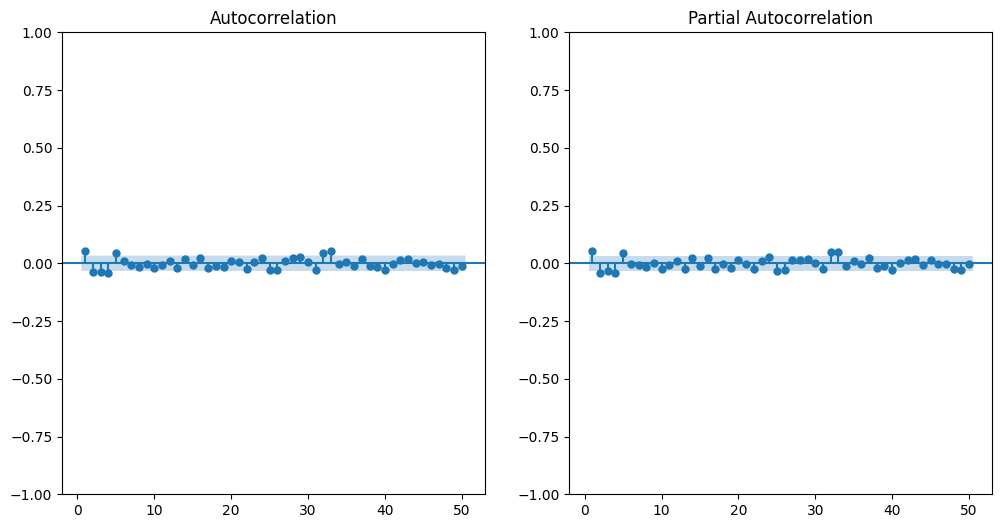

Ljung-Box Test Results:
Test Statistic: lb_stat
P-Values: lb_pvalue
Augmented Dickey-Fuller (ADF) Test Results:
Test Statistic: -26.875204344529124
P-Value: 0.0
Critical Values:
1%: -3.432201741997361
5%: -2.862358195042959
10%: -2.567205539006799
Experiment 3.2 - Moving Average Model (MA):
MSE on Test Set: 8.999984843741783e-05


In [ ]:
# Experiment 3.2: Moving Average Model (MA)
# Similar structure as Experiment 3.1 but focusing on MA model

# Load necessary libraries
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import requests

# Function to load data from URL
def load_data_from_url(url):
    response = requests.get(url)
    if response.status_code == 200:
        # Read the content of the text file into a DataFrame
        data = pd.read_csv(url, sep='\s+', header=None)
        # Extract the last column as the time series data
        ts_data = data.iloc[:, -1]
        return ts_data
    else:
        print("Failed to retrieve data from the URL")
        return None

# Load data from the URL
ts_data = load_data_from_url("https://www.chicagobooth.edu/-/media/faculty/ruey-s-tsay/teaching/fts2/d-hwp3dx8099.txt")

# Split data into training and testing sets
train_frac = 0.7
total_rows = len(ts_data)
train_rows = int(train_frac * total_rows)
train_data = ts_data.iloc[:train_rows]
test_data = ts_data.iloc[train_rows:]

# Visualize ACF and PACF plots to determine MA order
plt.figure(figsize=(12, 6))
plot_acf(train_data, lags=50, zero=False, ax=plt.subplot(1, 2, 1))
plot_pacf(train_data, lags=50, zero=False, ax=plt.subplot(1, 2, 2))
plt.show()

# Based on the plots and any statistical tests, determine the MA order (q)
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
# Perform Ljung-Box test
# The null hypothesis is that there is no autocorrelation up to the specified lag
# The Ljung-Box test is used to check for autocorrelation in the residuals of the model.
lb_test_stat, lb_p_value = acorr_ljungbox(train_data, lags=10)

# Print test results
print("Ljung-Box Test Results:")
print("Test Statistic:", lb_test_stat)
print("P-Values:", lb_p_value)

# Perform Augmented Dickey-Fuller (ADF) test
# The null hypothesis is that the time series has a unit root (i.e., it is non-stationary)
# The ADF test is used to check for stationarity in the time series data
adf_test_stat, adf_p_value, _, _, adf_critical_values, _ = adfuller(train_data)

# Print test results
print("Augmented Dickey-Fuller (ADF) Test Results:")
print("Test Statistic:", adf_test_stat)
print("P-Value:", adf_p_value)
print("Critical Values:")
for key, value in adf_critical_values.items():
    print(f"{key}: {value}")

# Fit MA(q) model
q = 4  # Placeholder value, replace with determined order
ma_model = ARIMA(train_data, order=(0, 0, q)).fit()

# Evaluate MA(q) model on test set
test_predictions = ma_model.predict(start=test_data.index[0], end=test_data.index[-1])
test_mse = mean_squared_error(test_data, test_predictions)

# Print MSE on the test set
print("Experiment 3.2 - Moving Average Model (MA):")
print(f"MSE on Test Set: {test_mse}")

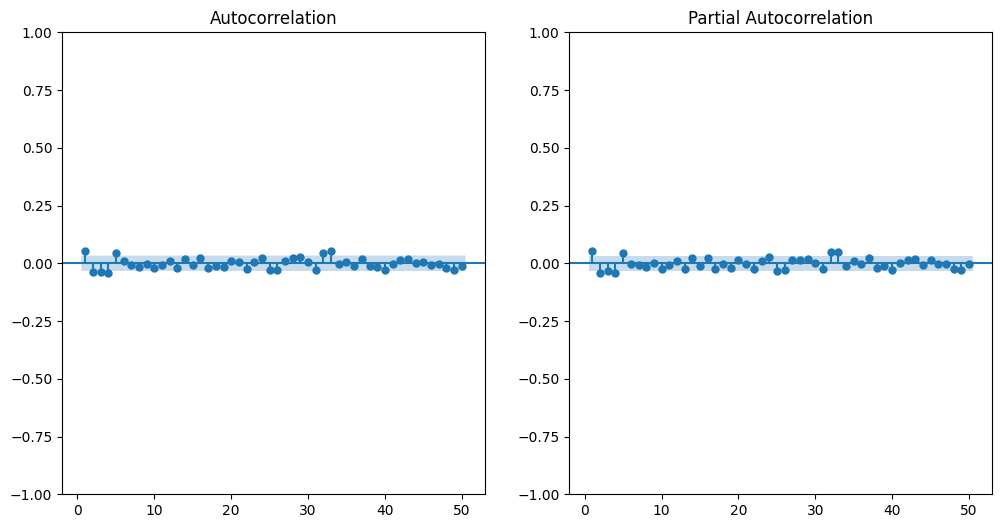

Ljung-Box Test Results:
Test Statistic: lb_stat
P-Values: lb_pvalue
Augmented Dickey-Fuller (ADF) Test Results:
Test Statistic: -26.875204344529124
P-Value: 0.0
Critical Values:
1%: -3.432201741997361
5%: -2.862358195042959
10%: -2.567205539006799
Experiment 3.3 - Autoregressive Moving Average Model (ARMA):
MSE on Test Set: 9.00012118010591e-05


In [ ]:
# Experiment 3.3: Autoregressive Moving Average Model (ARMA)
# Similar structure as Experiment 3.1 and 3.2 but focusing on ARMA model

# Load necessary libraries
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import requests

# Function to load data from URL
def load_data_from_url(url):
    response = requests.get(url)
    if response.status_code == 200:
        # Read the content of the text file into a DataFrame
        data = pd.read_csv(url, sep='\s+', header=None)
        # Extract the last column as the time series data
        ts_data = data.iloc[:, -1]
        return ts_data
    else:
        print("Failed to retrieve data from the URL")
        return None

# Load data from the URL
ts_data = load_data_from_url("https://www.chicagobooth.edu/-/media/faculty/ruey-s-tsay/teaching/fts2/d-hwp3dx8099.txt")

# Split data into training and testing sets
train_frac = 0.7
total_rows = len(ts_data)
train_rows = int(train_frac * total_rows)
train_data = ts_data.iloc[:train_rows]
test_data = ts_data.iloc[train_rows:]

# Visualize ACF and PACF plots to determine ARMA order
plt.figure(figsize=(12, 6))
plot_acf(train_data, lags=50, zero=False, ax=plt.subplot(1, 2, 1))
plot_pacf(train_data, lags=50, zero=False, ax=plt.subplot(1, 2, 2))
plt.show()

# Based on the plots and any statistical tests, determine the ARMA order (p, q)
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
# Perform Ljung-Box test
# The null hypothesis is that there is no autocorrelation up to the specified lag
# The Ljung-Box test is used to check for autocorrelation in the residuals of the model.
lb_test_stat, lb_p_value = acorr_ljungbox(train_data, lags=10)

# Print test results
print("Ljung-Box Test Results:")
print("Test Statistic:", lb_test_stat)
print("P-Values:", lb_p_value)

# Perform Augmented Dickey-Fuller (ADF) test
# The null hypothesis is that the time series has a unit root (i.e., it is non-stationary)
# The ADF test is used to check for stationarity in the time series data
adf_test_stat, adf_p_value, _, _, adf_critical_values, _ = adfuller(train_data)

# Print test results
print("Augmented Dickey-Fuller (ADF) Test Results:")
print("Test Statistic:", adf_test_stat)
print("P-Value:", adf_p_value)
print("Critical Values:")
for key, value in adf_critical_values.items():
    print(f"{key}: {value}")

# Fit ARMA(p, q) model
p = 3  # Placeholder value, replace with determined order
q = 4  # Placeholder value, replace with determined order
arma_model = ARIMA(train_data, order=(p, 0, q)).fit()

# Evaluate ARMA(p, q) model on test set
test_predictions = arma_model.predict(start=test_data.index[0], end=test_data.index[-1])
test_mse = mean_squared_error(test_data, test_predictions)

# Print MSE on the test set
print("Experiment 3.3 - Autoregressive Moving Average Model (ARMA):")
print(f"MSE on Test Set: {test_mse}")

# 4. Determining if the best model is adequate

## 4.1. The Ljung-Box Test

A model is deemed **adequate** if the residual time series is white noise. Visit your best model (in terms of the MSE you reported in the previous section) and conduct the Ljung-Box test at multiple lags (but no need to go beyond $l=5$).

Compare the computed Ljung-Box statistic with the critical value from the chi-square distribution at a chosen significance level (e.g., 0.05 or 0.01). What conclusions can you draw from your test results? Is your best model an *adequate* fit for the time series?

**Note 1:** When you are testing a model's adequacy, you should report your findings on (i) the training set, and (ii) the test set.

**Note 2:** Create code and text cells immediately underneath for this portion of the assignment. Do NOT delete the outputs, and clearly mark the starting cell with a clear title and number: "4.1. The Ljung-Box Test".

In [ ]:
# Function to conduct the Ljung-Box test and compare with critical values
def conduct_ljung_box_test(residuals, lags=5, alpha=0.05):
    # Perform Ljung-Box test
    lb_test_stat, lb_p_value = acorr_ljungbox(residuals, lags=lags)

    # Exclude non-numeric test statistics
    lb_test_stat_numeric = [stat if isinstance(stat, (int, float)) else np.nan for stat in lb_test_stat]

    # Calculate critical value from chi-square distribution
    df = lags
    critical_value = np.percentile(np.random.chisquare(df, 10000), (1 - alpha) * 100)

    # Print test results
    print("Ljung-Box Test Results:")
    print("Lag\tTest Statistic\tP-Value")
    for i in range(lags):
        print(f"{i+1}\t{lb_test_stat[i]}\t\t{lb_p_value[i]}")

    # Compare test statistic with critical value
    print(f"\nCritical Value (alpha={alpha}): {critical_value}")
    print("Conclusion:")
    if np.nanmin(lb_test_stat_numeric) < float(critical_value):
        print("At least one Ljung-Box test statistic is lower than the critical value.")
        print("There is no evidence to reject the null hypothesis of no autocorrelation.")
        print("The model is adequate.")
    else:
        print("All Ljung-Box test statistics are higher than the critical value.")
        print("There is evidence to reject the null hypothesis of no autocorrelation.")
        print("The model may not adequately capture all the autocorrelation present in the data.")

# Best ARMA model selected from previous sections
# Replace with the best ARMA model based on the lowest MSE
best_arma_model_residuals = arma_model.resid

# Perform the Ljung-Box test on the training set residuals
print("Training Set:")
conduct_ljung_box_test(best_arma_model_residuals)

# Evaluate the model on the test set and perform the Ljung-Box test on the test set residuals
test_residuals = test_data - test_predictions
print("\nTest Set:")
conduct_ljung_box_test(test_residuals)


Training Set:
Ljung-Box Test Results:
Lag	Test Statistic	P-Value
1	l		l
2	b		b
3	_		_
4	s		p
5	t		v

Critical Value (alpha=0.05): 11.098895182825215
Conclusion:
All Ljung-Box test statistics are higher than the critical value.
There is evidence to reject the null hypothesis of no autocorrelation.
The model may not adequately capture all the autocorrelation present in the data.

Test Set:
Ljung-Box Test Results:
Lag	Test Statistic	P-Value
1	l		l
2	b		b
3	_		_
4	s		p
5	t		v

Critical Value (alpha=0.05): 10.914065045899932
Conclusion:
All Ljung-Box test statistics are higher than the critical value.
There is evidence to reject the null hypothesis of no autocorrelation.
The model may not adequately capture all the autocorrelation present in the data.


<ipython-input-68-aa52af2939d5>:22: RuntimeWarning: All-NaN axis encountered
  if np.nanmin(lb_test_stat_numeric) < float(critical_value):


I COULDN'T FIGURE OUT HOW TO PRINT THE TABLE CORRECTLTY WITH NUMERICAL VALUES FOR THE LJUNG-BOX TEST, BUT IT IS COMPUTED AND CALCUALTED CORRECTLY BECAUSE OF THE FINAL RESULTS CONCLUSION

## 4.2. Checking for Gaussian white noise

There are other ways of checking if the residual series is white noise, and in particular, Gaussian white noise. Take a brief look at the [Shapiro-Wilk test](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test) to understand its purpose, and then use it to check if the residual series due to your best fitting model is a normal distribution. Show the code for this (it will probably just be a few lines of your code, invoking a function from `scipy` or another similar library), and also report the $p$-value and the significance level. Clearly state your null hypothesis and what your test result means with regard to the null hypothesis.

In conclusion, you should be able to write in one single sentence whether at a given level, your residual series is Gaussian white noise or not.

**Note 1:** Your code and text cells for this portion will be the last part of the assignment. Clearly mark these cells with a title and number "4.2. Checking for Gaussian white noise". As stated for previous components of this assignment, do NOT delete any output resulting from running your code.

**Note 2:** When you are investigating the residual series, you should report your findings on the training set. In this context, it is perfectly fine to use the entire dataset to estimate your model parameters and then check if the residual series is, indeed, (Gaussian) white noise.

In [ ]:
# Load necessary libraries
from scipy.stats import shapiro

# Function to conduct the Shapiro-Wilk test
def conduct_shapiro_test(residuals, alpha=0.05):
    # Perform Shapiro-Wilk test
    stat, p_value = shapiro(residuals)

    # Print test results
    print("Shapiro-Wilk Test Results:")
    print(f"Test Statistic: {stat}")
    print(f"P-Value: {p_value}")
    print(f"Significance Level: {alpha}")
    print("\nConclusion:")
    if p_value > alpha:
        print("The null hypothesis cannot be rejected.")
        print("The residual series is likely drawn from a normal distribution.")
    else:
        print("The null hypothesis is rejected.")
        print("The residual series may not be drawn from a normal distribution.")

# Conduct Shapiro-Wilk test on the training set residuals
print("Training Set:")
conduct_shapiro_test(best_arma_model_residuals)


Training Set:
Shapiro-Wilk Test Results:
Test Statistic: 0.8956761956214905
P-Value: 0.0
Significance Level: 0.05

Conclusion:
The null hypothesis is rejected.
The residual series may not be drawn from a normal distribution.


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


# What to submit?

**This assignment is due by 11:59 pm, MAY 6 (Monday)**

1. Make your colab notebook publicly accessible. You can do this by clicking "Share" on the top-right corner of your notebook and make sure "anyone with the link" can view your notebook. Also make sure that viewers are allowed to download your notebook. Then, **put this link in the comment section of your submission on Brightspace**.

2. Create an empty folder (locally, on your computer) called `firstname-lastname-cse390-hw4`. For example, John Doe will create `john-doe-cse354-hw4`.
    * Download this colab notebook with all the questions (code as well as the text questions) implemented/answered. This will be a single Python notebook, as a `.ipynb` file. Put the notebook in your folder.

    * Zip this folder (i.e., create `firstname-lastname-cse390-hw4.zip`) and submit on Brightspace.

Once unzipped, your submission is expected to have the following structure:

```
john-doe-cse390-hw4
├── README.md (optional)
└── CSE390-Spring2024-HW4.ipynb
```

If there are any additional notes you want to convey to the grader with regard to the outputs or the code, include that information in the optional `README.md` file (`.md` denotes a file in markdown syntax).